In [4]:
import os
from PIL import Image
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
from torch.utils.data import DataLoader, Dataset
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
from tempfile import TemporaryDirectory
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_recall_fscore_support
import torch.nn.functional as F
from tqdm import tqdm

In [2]:
dir_path = "C:/Users/joann/Documents/PlantVillage-Dataset/raw/color"

In [3]:
data = []
label_names = []
distinct_labels = set()
directory = os.listdir(dir_path)
for subdir in directory:
    subdir_path = os.path.join(dir_path, subdir)
    subdirectory = os.listdir(subdir_path)
    for image in subdirectory:
        img = np.asarray(Image.open(os.path.join(subdir_path, image)))
        if img.shape == (256, 256, 3):
            data.append(img)
            label_names.append(subdir)
            distinct_labels.add(subdir)
data = np.array(data)
label_names = np.array(label_names)
distinct_labels = sorted(distinct_labels)

In [4]:
print(data.shape)
print(label_names.shape)

(54304, 256, 256, 3)
(54304,)


In [5]:
labels = []
for i in label_names:
    labels.append(distinct_labels.index(i))
labels = np.array(labels).astype(np.int64)
print(labels)

[ 0  0  0 ... 35 35 35]


In [6]:
torch.cuda.is_available()

True

In [7]:
X_train, X_val, y_train, y_val = train_test_split(data, labels, test_size=0.20)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.10)

In [8]:
class PlantVillageDataset(Dataset):
    def __init__(self, data, labels, transform=None, target_transform=None):
        self.data = data
        self.labels = labels
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = self.data[idx]
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [20]:
data_transforms = {
    'train': transforms.Compose([
        transforms.ToTensor(),
        transforms.RandomRotation(180),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    ]),
    'val': transforms.Compose([
        transforms.ToTensor(),
    ]),
}

loaders = {'train': DataLoader(PlantVillageDataset(X_train, y_train, transform=data_transforms['train']), shuffle=True, batch_size=32), \
           'val': DataLoader(PlantVillageDataset(X_val, y_val, transform=data_transforms['val']), shuffle=True, batch_size=32), \
           'test': DataLoader(PlantVillageDataset(X_test, y_test, transform=data_transforms['val']), shuffle=True, batch_size=32)}
dataset_sizes = {'train': len(X_train), 'val': len(X_val), 'test': len(X_test)}
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
losses = {'train': [], 'val': []}
accs = {'train': [], 'val': []}

In [21]:
class NaiveCNN(nn.Module):
    def __init__(self):
        super(NaiveCNN, self).__init__()

        self.feature_extractor = nn.Sequential(
            nn.Conv2d(3, 8, 3, padding=1),
            nn.LeakyReLU(0.01),
            nn.Conv2d(8, 32, 3, padding=1),
            nn.LeakyReLU(0.01),
            nn.MaxPool2d(2),
            nn.Dropout(0.2),
            nn.Conv2d(32, 32, 3, padding=1),
            nn.LeakyReLU(0.01),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.LeakyReLU(0.01),
            nn.MaxPool2d(2),
            nn.Dropout(0.2),
        )

        self.avg_pooling = nn.AdaptiveAvgPool2d((7, 7))

        self.classifier = nn.Sequential(
            nn.Linear(49 * 64, 256),
            nn.LeakyReLU(0.01),
            nn.Dropout(0.2),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.01),
            nn.Dropout(0.2),
            nn.Linear(128, len(distinct_labels))
        )

    def forward(self, x):
        x = self.feature_extractor(x)
        x = self.avg_pooling(x)
        x = torch.flatten(x, start_dim=1)
        return self.classifier(x)

In [11]:
def train(model, criterion, optimizer, scheduler):
    model.train()
    total_loss = 0.0
    total_correct = 0

    for inputs, labels in tqdm(loaders['train']):
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()

        with torch.enable_grad():
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        total_loss += loss.item() * inputs.size(0)
        total_correct += torch.sum(preds == labels.data)
    scheduler.step()

    train_loss = total_loss / dataset_sizes['train']
    train_acc = total_correct.cpu() / dataset_sizes['train']
    losses['train'].append(train_loss)
    accs['train'].append(train_acc)
    return train_loss, train_acc

In [12]:
def val(model, criterion):
    model.eval()
    total_loss = 0.0
    total_correct = 0

    for inputs, labels in loaders['val']:
        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

        total_loss += loss.item() * inputs.size(0)
        total_correct += torch.sum(preds == labels.data)

    val_loss = total_loss / dataset_sizes['val']
    val_acc = total_correct.cpu() / dataset_sizes['val']
    losses['val'].append(val_loss)
    accs['val'].append(val_acc)
    return val_loss, val_acc

In [13]:
def test(model, criterion):
    model.eval()
    total_loss = 0.0
    total_correct = 0
    true_labels = []
    pred_labels = []

    for inputs, labels in loaders['test']:
        inputs = inputs.to(device)
        true_labels.extend(labels)
        labels = labels.to(device)

        with torch.no_grad():
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            pred_labels.extend(preds.cpu())
            loss = criterion(outputs, labels)

        total_loss += loss.item() * inputs.size(0)
        total_correct += torch.sum(preds == labels.data)

    test_loss = total_loss / dataset_sizes['test']
    test_acc = total_correct / dataset_sizes['test']
    conf_matrix = confusion_matrix(true_labels, pred_labels)
    precision, recall, f1, _ = precision_recall_fscore_support(true_labels, pred_labels, average='weighted')
    return test_loss, test_acc, conf_matrix, precision, recall, f1

In [22]:
model = NaiveCNN()
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [24]:
num_epochs = 25
best_model_params_path = "naivecnncheckpoints/best_model_params.pt"

torch.save(model.state_dict(), best_model_params_path)
best_acc = 0.0

for epoch in range(num_epochs):
    print(f'Epoch {epoch + 1}/{num_epochs}')
    print('-' * 10)

    train_loss, train_acc = train(model, criterion, optimizer, scheduler)
    val_loss, val_acc = val(model, criterion)

    print(f'Train Loss: {train_loss:.4f} Acc: {train_acc:.4f}')
    print(f'Validation Loss: {val_loss:.4f} Acc: {val_acc:.4f}')

    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), best_model_params_path)  
    print()

print(f'Best Validation Acc: {best_acc:4f}')

Epoch 1/25
----------


100%|██████████| 1358/1358 [10:18<00:00,  2.20it/s]


Train Loss: 2.3467 Acc: 0.3456
Validation Loss: 1.5629 Acc: 0.5363

Epoch 2/25
----------


100%|██████████| 1358/1358 [10:24<00:00,  2.18it/s]


Train Loss: 1.5234 Acc: 0.5495
Validation Loss: 1.1978 Acc: 0.6466

Epoch 3/25
----------


100%|██████████| 1358/1358 [10:22<00:00,  2.18it/s]


Train Loss: 1.1990 Acc: 0.6364
Validation Loss: 0.9007 Acc: 0.7139

Epoch 4/25
----------


100%|██████████| 1358/1358 [11:08<00:00,  2.03it/s]


Train Loss: 1.0111 Acc: 0.6869
Validation Loss: 0.7392 Acc: 0.7668

Epoch 5/25
----------


100%|██████████| 1358/1358 [11:19<00:00,  2.00it/s]


Train Loss: 0.9001 Acc: 0.7193
Validation Loss: 0.6772 Acc: 0.7861

Epoch 6/25
----------


100%|██████████| 1358/1358 [11:36<00:00,  1.95it/s]


Train Loss: 0.8059 Acc: 0.7456
Validation Loss: 0.5943 Acc: 0.8082

Epoch 7/25
----------


100%|██████████| 1358/1358 [11:27<00:00,  1.98it/s]


Train Loss: 0.7224 Acc: 0.7740
Validation Loss: 0.5901 Acc: 0.8063

Epoch 8/25
----------


100%|██████████| 1358/1358 [11:33<00:00,  1.96it/s]


Train Loss: 0.5537 Acc: 0.8219
Validation Loss: 0.4188 Acc: 0.8635

Epoch 9/25
----------


100%|██████████| 1358/1358 [11:32<00:00,  1.96it/s]


Train Loss: 0.5246 Acc: 0.8310
Validation Loss: 0.3895 Acc: 0.8740

Epoch 10/25
----------


100%|██████████| 1358/1358 [10:42<00:00,  2.11it/s]


Train Loss: 0.5009 Acc: 0.8357
Validation Loss: 0.3776 Acc: 0.8755

Epoch 11/25
----------


100%|██████████| 1358/1358 [11:05<00:00,  2.04it/s]


Train Loss: 0.4837 Acc: 0.8419
Validation Loss: 0.3643 Acc: 0.8829

Epoch 12/25
----------


100%|██████████| 1358/1358 [11:20<00:00,  2.00it/s]


Train Loss: 0.4721 Acc: 0.8460
Validation Loss: 0.3620 Acc: 0.8812

Epoch 13/25
----------


100%|██████████| 1358/1358 [11:47<00:00,  1.92it/s]


Train Loss: 0.4661 Acc: 0.8465
Validation Loss: 0.3560 Acc: 0.8844

Epoch 14/25
----------


100%|██████████| 1358/1358 [12:06<00:00,  1.87it/s]


Train Loss: 0.4576 Acc: 0.8487
Validation Loss: 0.3464 Acc: 0.8855

Epoch 15/25
----------


100%|██████████| 1358/1358 [11:41<00:00,  1.94it/s]


Train Loss: 0.4356 Acc: 0.8568
Validation Loss: 0.3401 Acc: 0.8876

Epoch 16/25
----------


100%|██████████| 1358/1358 [12:08<00:00,  1.86it/s]


Train Loss: 0.4308 Acc: 0.8573
Validation Loss: 0.3371 Acc: 0.8899

Epoch 17/25
----------


100%|██████████| 1358/1358 [11:51<00:00,  1.91it/s]


Train Loss: 0.4280 Acc: 0.8600
Validation Loss: 0.3356 Acc: 0.8903

Epoch 18/25
----------


100%|██████████| 1358/1358 [15:45<00:00,  1.44it/s]


Train Loss: 0.4301 Acc: 0.8583
Validation Loss: 0.3319 Acc: 0.8919

Epoch 19/25
----------


100%|██████████| 1358/1358 [11:52<00:00,  1.91it/s]


Train Loss: 0.4285 Acc: 0.8583
Validation Loss: 0.3317 Acc: 0.8918

Epoch 20/25
----------


100%|██████████| 1358/1358 [11:25<00:00,  1.98it/s]


Train Loss: 0.4251 Acc: 0.8601
Validation Loss: 0.3303 Acc: 0.8923

Epoch 21/25
----------


100%|██████████| 1358/1358 [11:25<00:00,  1.98it/s]


Train Loss: 0.4243 Acc: 0.8621
Validation Loss: 0.3289 Acc: 0.8917

Epoch 22/25
----------


100%|██████████| 1358/1358 [11:26<00:00,  1.98it/s]


Train Loss: 0.4264 Acc: 0.8581
Validation Loss: 0.3276 Acc: 0.8917

Epoch 23/25
----------


100%|██████████| 1358/1358 [11:25<00:00,  1.98it/s]


Train Loss: 0.4206 Acc: 0.8627
Validation Loss: 0.3284 Acc: 0.8918

Epoch 24/25
----------


100%|██████████| 1358/1358 [11:58<00:00,  1.89it/s]


Train Loss: 0.4247 Acc: 0.8602
Validation Loss: 0.3273 Acc: 0.8917

Epoch 25/25
----------


100%|██████████| 1358/1358 [12:57<00:00,  1.75it/s]


Train Loss: 0.4238 Acc: 0.8604
Validation Loss: 0.3275 Acc: 0.8921

Best Validation Acc: 0.892265


In [25]:
test_loss, test_acc, conf_matrix, precision, recall, f1 = test(model, criterion)

Test Loss: 0.306169
Test Acc: 0.894204
Precision: 0.8972806176048754
Recall: 0.8942042318307267
F1: 0.8910044947436387


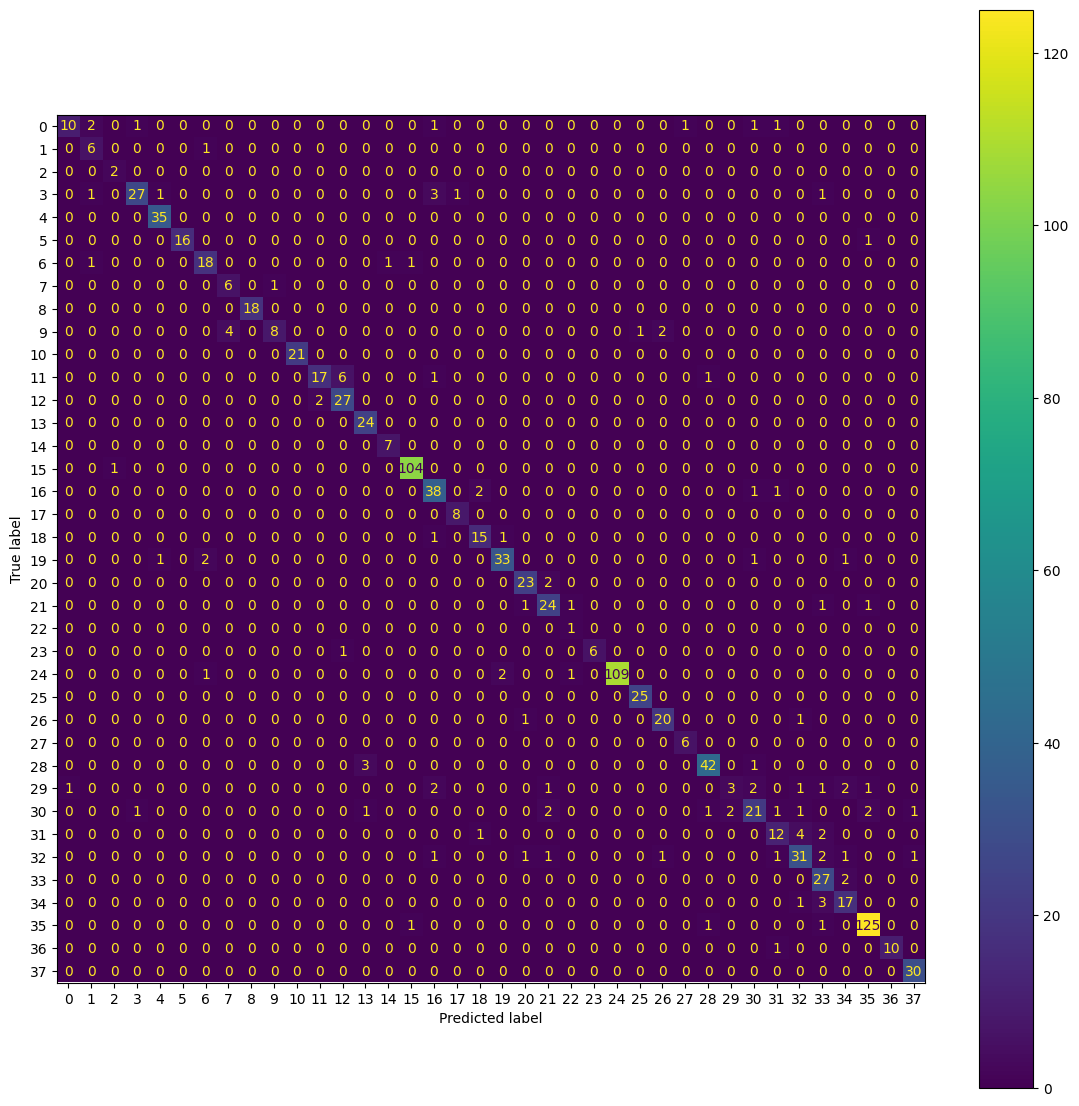

In [26]:
print(f'Test Loss: {test_loss:4f}')
print(f'Test Acc: {test_acc:4f}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1: {f1}')
cmp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
fig, ax = plt.subplots(figsize=(14, 14))
cmp.plot(ax=ax)
plt.savefig('naivecnn20epochs/confusionmatrix.png')

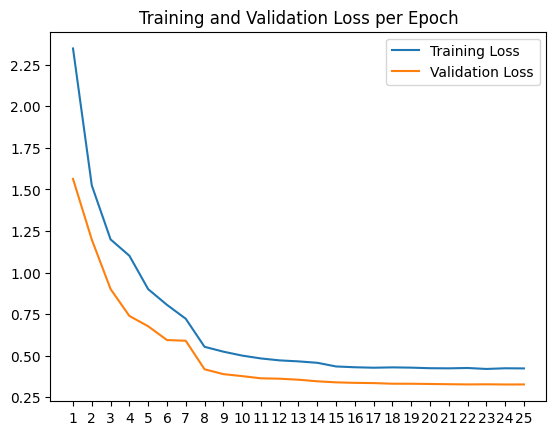

In [6]:
epochs = [i for i in range(1, num_epochs + 1)]
plt.plot(epochs, losses['train'], label="Training Loss")
plt.plot(epochs, losses['val'], label="Validation Loss")
plt.xticks(epochs)
plt.title("Training and Validation Loss per Epoch")
plt.legend()
plt.savefig('naivecnn20epochs/loss.png')

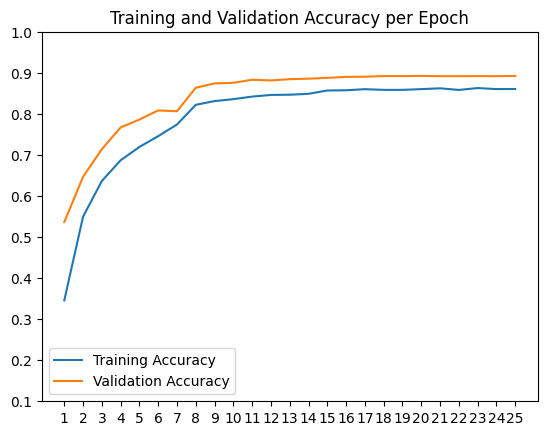

In [7]:
epochs = [i for i in range(1, num_epochs + 1)]
plt.plot(epochs, accs['train'], label="Training Accuracy")
plt.plot(epochs, accs['val'], label="Validation Accuracy")
plt.xticks(epochs)
plt.yticks(np.arange(0.1, 1.05, 0.1))
plt.title("Training and Validation Accuracy per Epoch")
plt.legend()
plt.savefig('naivecnn20epochs/accuracy.png')

In [34]:
def imshow(inp):
    inp = np.swapaxes(inp, 0, 2)
    inp = np.swapaxes(inp, 0, 1)
    plt.imshow(np.array(inp), vmin=0, vmax=1)

In [37]:
def visualize_model(model, num_images=6):
    model.eval()
    image_count = 0
    fig = plt.figure(figsize=(12, 12))

    with torch.no_grad():
        for _, (inputs, labels) in enumerate(loaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                image_count += 1
                ax = plt.subplot(num_images//2, 2, image_count)
                ax.axis('off')
                ax.set_title(f'predicted: {distinct_labels[preds[j]]}')
                imshow(inputs[j].cpu())

                if image_count == num_images:
                    fig.savefig('naivecnn20epochs/predictions.png', format="png")
                    return

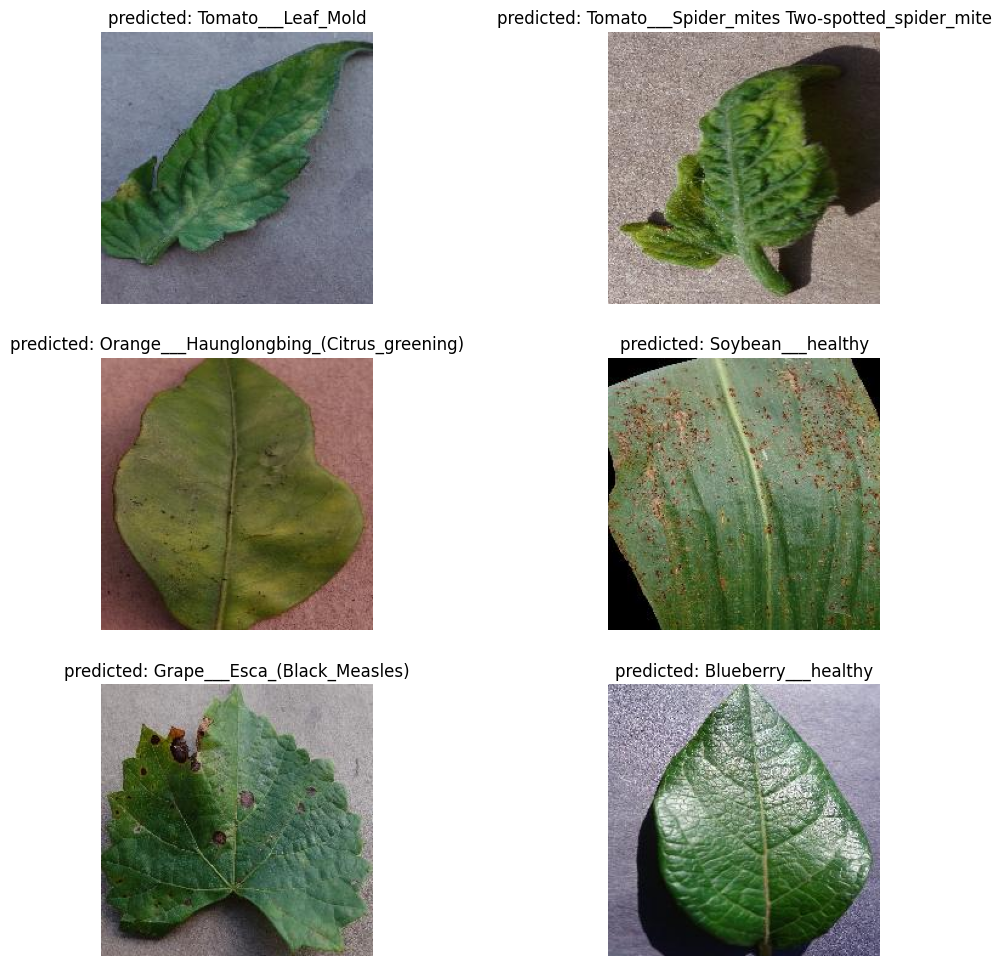

In [38]:
visualize_model(model)